<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/DecisionTreeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [41]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Importando dados 

In [89]:
dataset = pd.read_csv("dados_ies_novas_categorias_utf8.csv", index_col=0, encoding="latin-1")

# Selecionando features

Transformando strings em ints para serem usados como features

In [81]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(dataset["REGIAO"])
dataset["REGIAO"]=le.transform(dataset["REGIAO"])
le_name_mapping_2 = dict(zip(le.classes_, le.transform(le.classes_)))

le.fit(dataset["UF"])
dataset["UF"]=le.transform(dataset["UF"])
le_name_mapping_3 = dict(zip(le.classes_, le.transform(le.classes_)))

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import json
b = json.dumps(le_name_mapping_2, default=np_encoder, indent=True, ensure_ascii=False)
c = json.dumps(le_name_mapping_3, default=np_encoder, indent=True, ensure_ascii=False)

ff = '{'
ff += f'\n"REGIAO": [\n{b}\n],\n"UF": [\n{c}\n]'
ff += '\n}'

f = open("mapa_categorias.json", "w")
f.write(ff)
f.close()

dataset.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,Nacional,0,10,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,Nacional,0,6,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,Nacional,1,24,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,Nacional,2,3,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000
4,100,5,Nacional,1,17,137.0,50.0,73.0,36.0,3.0,4.200000,5.880000,5.880000,2.520000,2.520000


In [90]:
X = dataset.drop(columns=[
                          "TIPO_CATEGORIA_ADM",
                          "CODIGO_IES",
                          "NUM_CURSOS",
                          "REGIAO",
                          "UF"
                          ])
y = dataset["TIPO_CATEGORIA_ADM"].values

feature_cols = [
                "DEFICIENCIA_FISICA",
                "DEFICIENCIA_VISUAL",
                "DEFICIENCIA_COGNITIVA",
                "DEFICIENCIA_AUDITIVA",
                "DEFICIENCIA_MULTIPLA",
                "RECURSOS_DEF_FISICA",
                "RECURSOS_DEF_VISUAL",
                "RECURSOS_DEF_COGNITIVA",
                "RECURSOS_DEF_AUDITIVA",
                "RECURSOS_DEF_MULTIPLA"
                ]

print(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1) #60% para treino e 40% para teste

      DEFICIENCIA_FISICA  ...  RECURSOS_DEF_MULTIPLA
0                   92.0  ...               0.201754
1                   39.0  ...               1.852349
2                  190.0  ...               0.534483
3                   64.0  ...               0.000000
4                  137.0  ...               2.520000
...                  ...  ...                    ...
2601                 0.0  ...               0.000000
2602                 1.0  ...               0.000000
2603                 1.0  ...               0.000000
2605                 1.0  ...               1.000000
2607                 1.0  ...               2.000000

[235 rows x 10 columns]


# Criando a árvore

In [91]:
da = DecisionTreeClassifier()

da = da.fit(X_train, y_train)

y_pred = da.predict(X_test)

# Avaliação do algoritmo

In [92]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.7553191489361702
Precision: 0.7526461113667741
Recall: 0.7553191489361702


# Visualizando a árvore

In [93]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

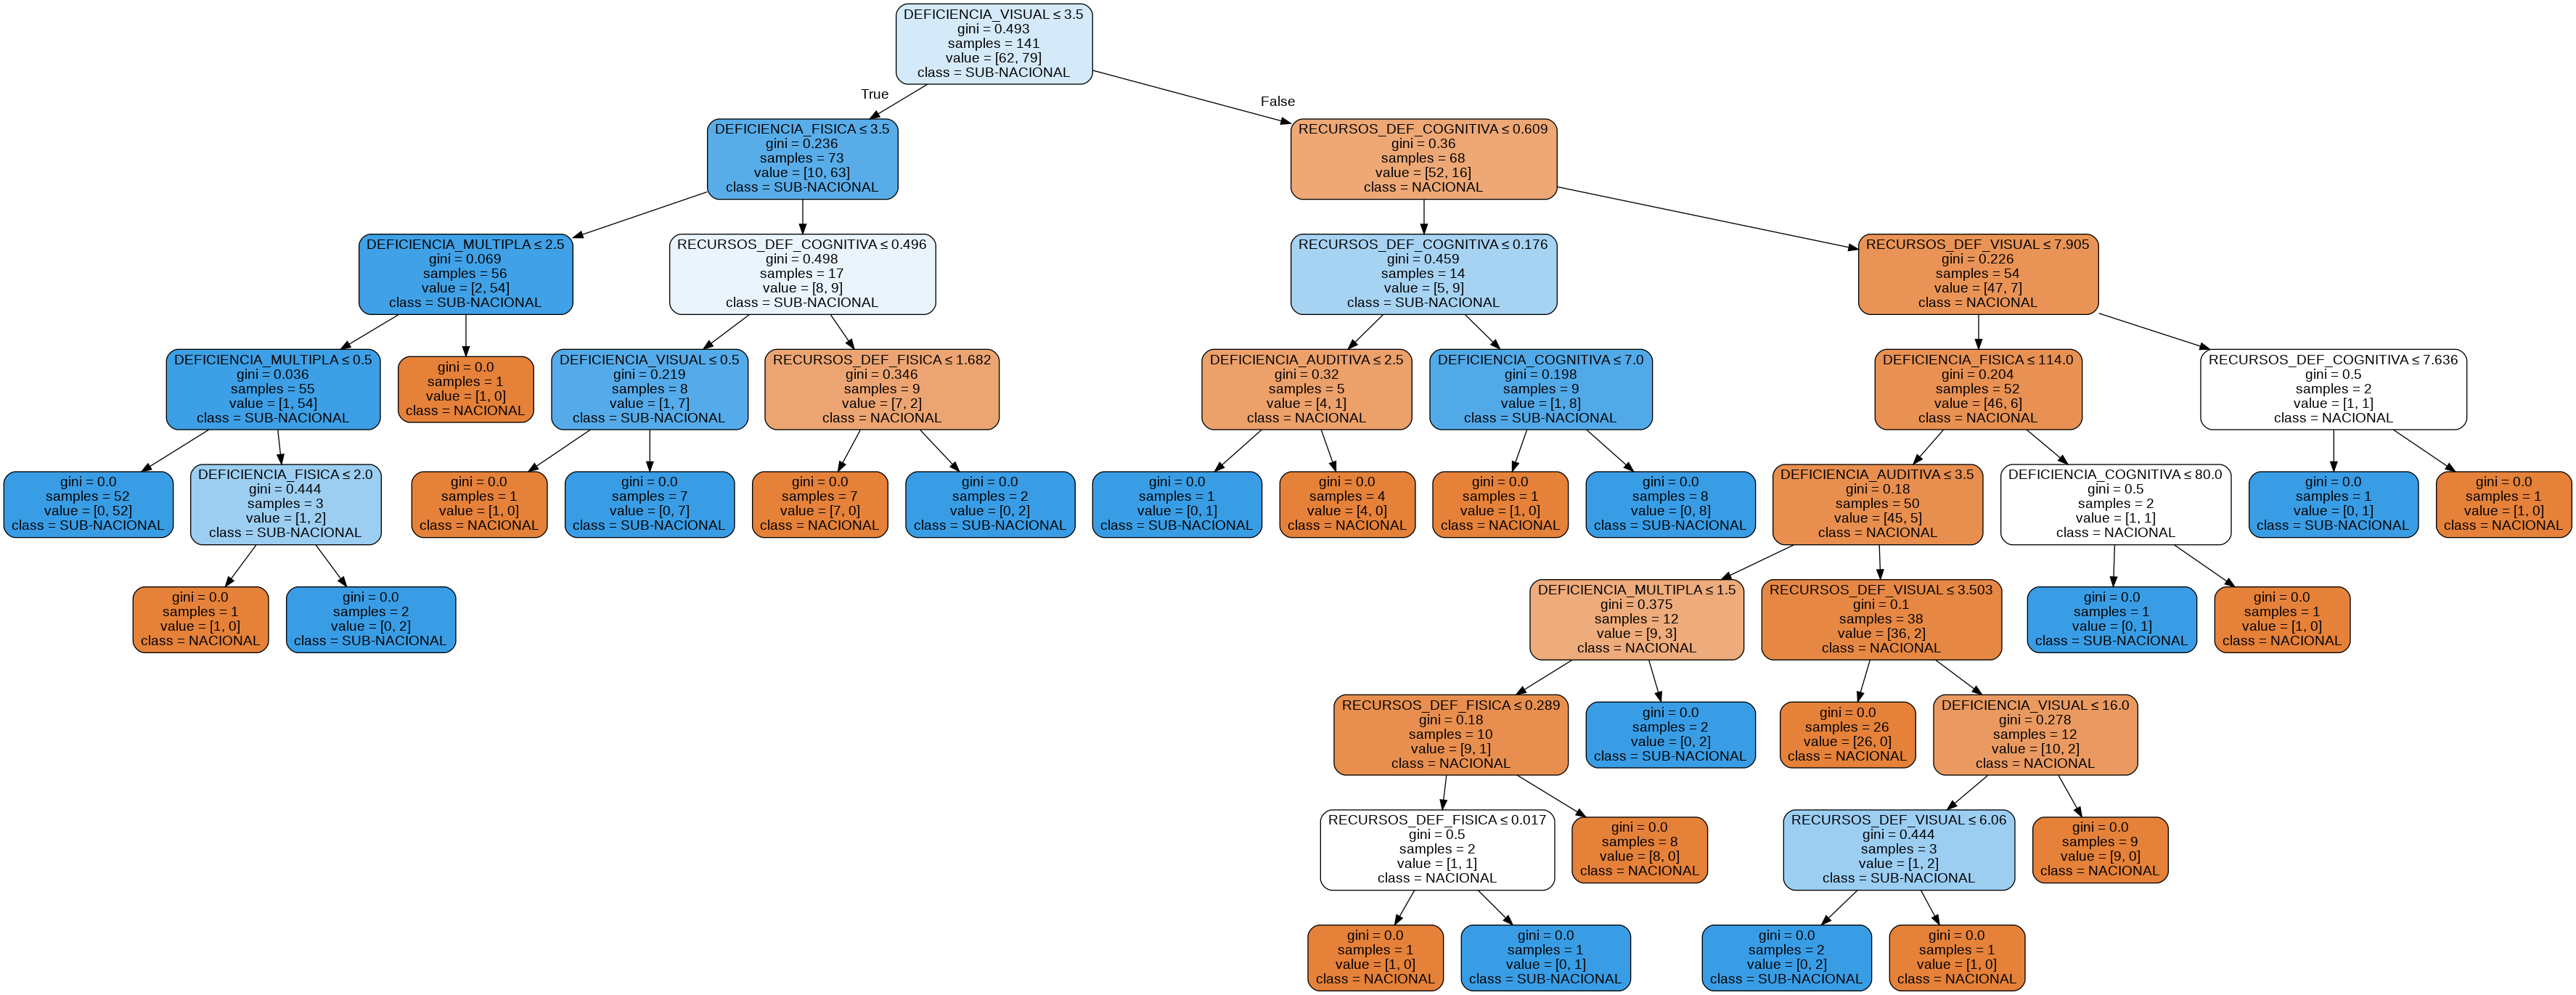

In [94]:
ddata = StringIO()
export_graphviz(
                da, 
                out_file=ddata, 
                filled=True, 
                rounded=True, 
                special_characters=True, 
                feature_names=feature_cols, 
                class_names=["NACIONAL", "SUB-NACIONAL"]
                )
graph = pydotplus.graph_from_dot_data(ddata.getvalue())
graph.write_png("categoria_administrativa.png")
Image(graph.create_png())

# Usando o feature importance

In [95]:
features_dict= {}
for col, val in sorted(zip(X_train.columns, da.feature_importances_), key=lambda x:x[1], reverse=True):
  features_dict[col] = val

features_df = pd.DataFrame({'Feature':features_dict.keys(),'Importance': features_dict.values()})

features_df

,Feature,Importance
0,DEFICIENCIA_AUDITIVA,0.453318
1,RECURSOS_DEF_AUDITIVA,0.194560
2,DEFICIENCIA_FISICA,0.099046
3,DEFICIENCIA_MULTIPLA,0.075190
4,RECURSOS_DEF_FISICA,0.070689
5,DEFICIENCIA_VISUAL,0.039982
6,RECURSOS_DEF_VISUAL,0.033959
7,DEFICIENCIA_COGNITIVA,0.033257
8,RECURSOS_DEF_COGNITIVA,0.000000
9,RECURSOS_DEF_MULTIPLA,0.000000


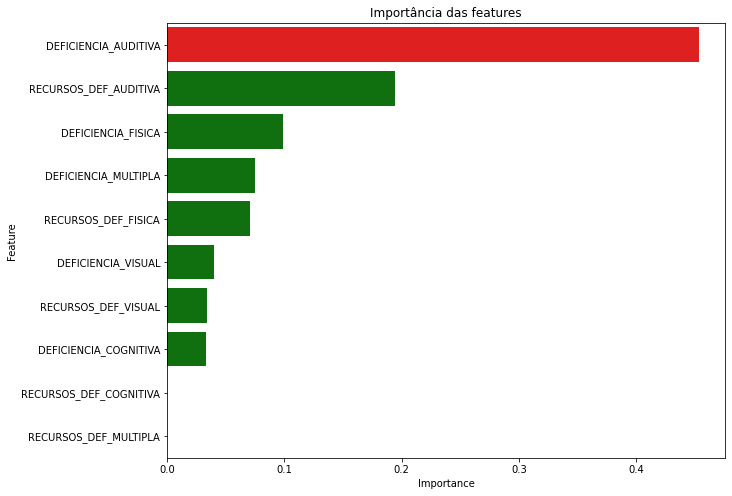

In [96]:
vals = features_df.Importance
id = features_df.Feature
plt.figure(figsize=(10, 8))
c = ['green' if (x < max(vals)) else 'red' for x in vals]
sns.barplot(y=id, x=vals, palette=c).set(title="Importância das features")
plt.show()